In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from spec_id import RT_spec
from glob import glob
from astropy.io import fits, ascii
from astropy.table import Table
from scipy.interpolate import interp1d
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
gsDB = pd.read_pickle('../data/good_spec_gal_DB.pkl')

In [4]:
def Best_fit_model(input_file, metal, age, redshift):
    chi = np.load(input_file)

    x = np.argwhere(chi == np.min(chi))
    print metal[x[0][0]], age[x[0][1]], redshift[x[0][2]]
    return metal[x[0][0]], age[x[0][1]], redshift[x[0][2]]

In [12]:
gsDB

,gids,ids,redshift,hmag,ra,dec,agn,in_data,spec,flt_files,flt_xpos,flt_ypos,low_res_specz,hi_res_specz
43,n14713,14713,1.134,22.557517,189.236333,62.214608,False,True,True,../../../Clear_data/flt_files/icat12tqq_flt.fits,480.823147,636.879341,1.234,1.232
47,n15616,15616,1.250,23.162718,189.238403,62.218809,False,True,True,../../../Clear_data/flt_files/icat12tqq_flt.fits,557.760340,731.676403,0.950,0.787
49,n16758,16758,0.992,21.618617,189.162357,62.224840,False,True,True,../../../Clear_data/flt_files/icxt36jqq_flt.fits,103.350402,901.345306,0.992,1.014
50,n17070,17070,1.226,21.592234,189.268086,62.226445,False,True,True,../../../Clear_data/flt_files/icat25hcq_flt.fits,637.268350,823.317758,1.176,1.192
51,n17436,17436,0.869,22.379914,189.171078,62.227726,False,True,True,../../../Clear_data/flt_files/icxt36jmq_flt.fits,20.935569,1013.208080,0.869,0.903
58,n19442,19442,1.007,23.317546,189.123036,62.237460,False,True,True,../../../Clear_data/flt_files/icat03dzq_flt.fits,30.768618,1009.307349,1.207,1.343
61,n21156,21156,1.201,21.327907,189.239409,62.247548,False,True,True,../../../Clear_data/flt_files/icxt51jvq_flt.fits,279.865494,838.707094,1.251,1.255
62,n21427,21427,1.479,22.540644,189.368121,62.247344,False,True,True,../../../Clear_data/flt_files/icat26dyq_flt.fits,-19.664813,572.418137,1.579,1.514
68,n23254,23254,1.457,23.460559,189.349606,62.255761,False,True,True,../../../Clear_data/flt_files/icat26dyq_flt.fits,290.163896,661.958820,1.357,1.338
69,n23435,23435,1.092,22.902048,189.338306,62.256571,False,True,True,../../../Clear_data/flt_files/icat26dyq_flt.fits,422.330798,604.972381,1.142,1.133


In [14]:
# pd.to_pickle(gsDB,'../data/good_spec_gal_DB.pkl')

In [15]:
hr_list = glob('../rshift_dat/*hires_z_fit.npy')
lr_list = glob('../rshift_dat/*lowres_z_fit.npy')
# lr_list = glob('../rshift_dat/*lowres_Pofz.npy')

In [19]:
metal=np.array([0.002,0.005,0.01,0.015,0.02,0.025,0.03])
age=np.array([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5])


for i in range(len(lr_list)):
    print gsDB['gids'][gsDB.index[i]]
    z=np.arange(gsDB['low_res_specz'][gsDB.index[i]] - 0.5 ,gsDB['low_res_specz'][gsDB.index[i]] + 0.5,.05)
    Best_fit_model(lr_list[i],metal,age,z)

n14713
0.015 0.5 1.234
n15616
0.03 0.5 0.75
n16758
0.02 0.5 1.142
n17070
0.015 0.5 1.176
n17436
0.03 0.5 0.369
n19442
0.015 0.5 1.207
n21156
0.015 0.5 1.251
n21427
0.01 0.5 1.579
n23254
0.002 0.5 1.357
n23435
0.02 0.5 1.142
n32566
0.015 0.5 1.078
n34694
0.02 0.5 1.137
n35835
0.015 0.5 0.325
n37686
0.02 0.5 1.272
n37765
0.002 0.5 1.533
n37896
0.002 0.5 1.758
n38126
0.005 0.5 1.259
n38225
0.03 0.5 0.968
s26272
0.002 0.5 1.732
s29257
0.002 0.5 1.889
s35774
0.015 0.5 1.234
s38785
0.015 0.5 1.18
s39012
0.01 0.5 1.612
s39170
0.02 0.5 1.034
s39241
0.03 0.5 0.998
s39631
0.025 0.5 1.031
s39804
0.025 0.5 1.314
s39805
0.015 0.5 1.208
s40223
0.01 0.5 1.602
s40476
0.015 0.5 1.193
s40597
0.015 0.5 1.24
s40623
0.025 0.5 1.406
s40862
0.025 0.5 1.336
s41148
0.03 0.5 1.771
s41520
0.03 0.5 1.387
s41659
0.025 0.5 1.443
s42221
0.03 0.5 0.596
s42548
0.002 0.5 1.725
s43615
0.03 0.5 1.039
s44042
0.015 0.5 1.62
s44620
0.03 0.5 1.08
s45972
0.02 0.5 1.047
s46066
0.03 0.5 1.319
s46345
0.015 0.5 1.352
s47677
0.03 

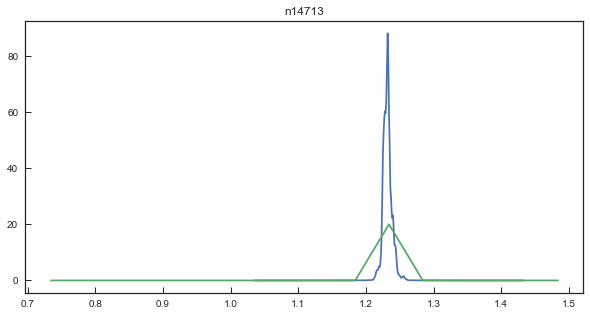

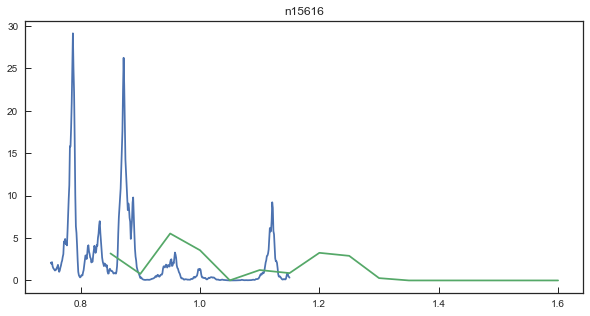

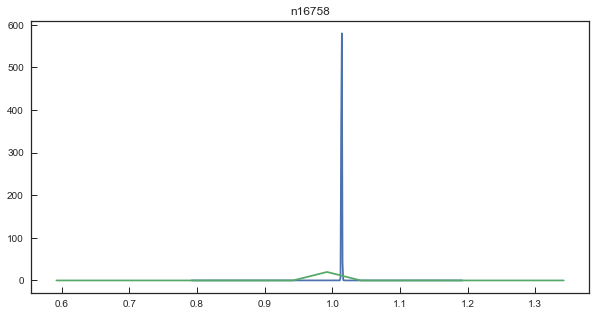

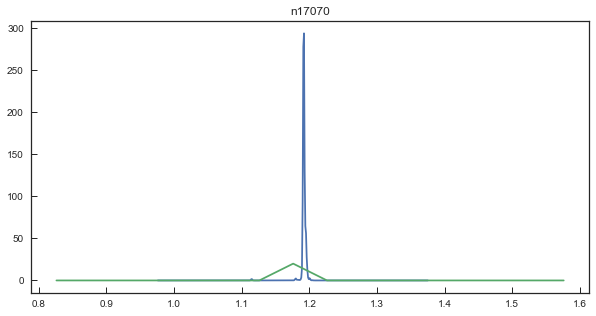

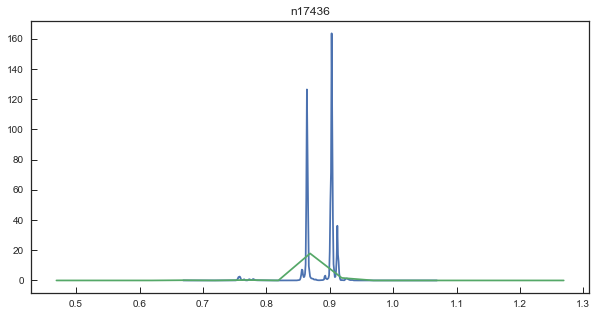

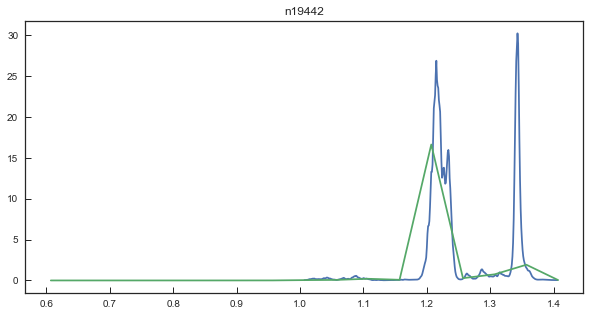

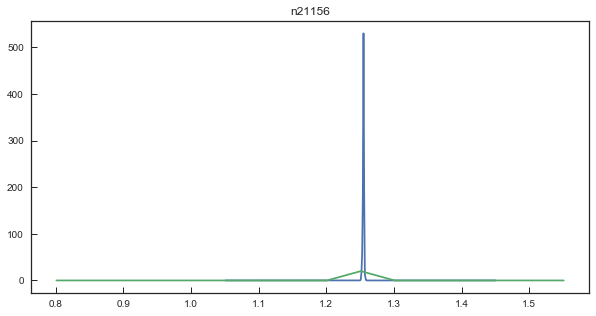

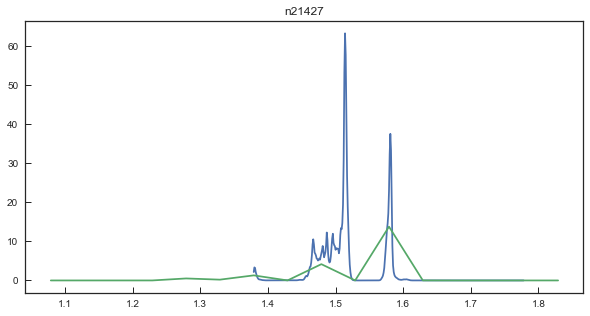

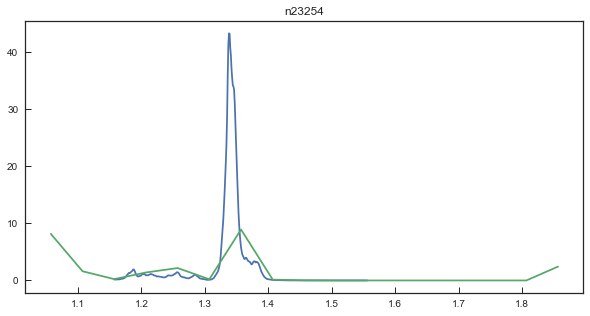

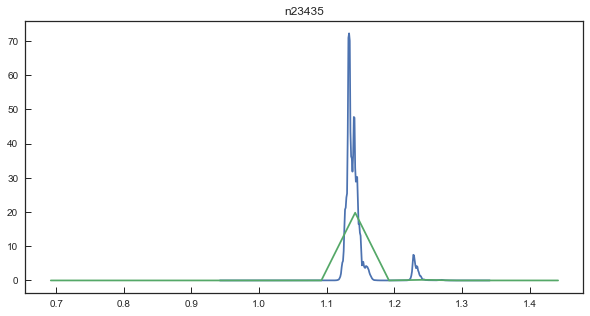

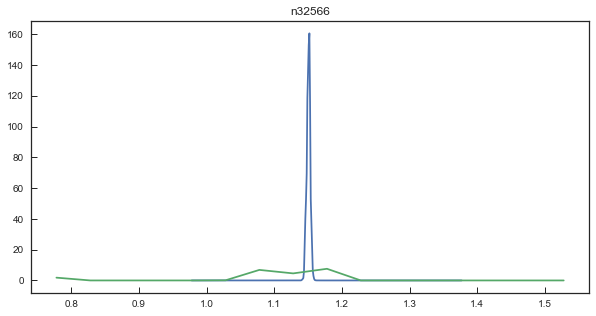

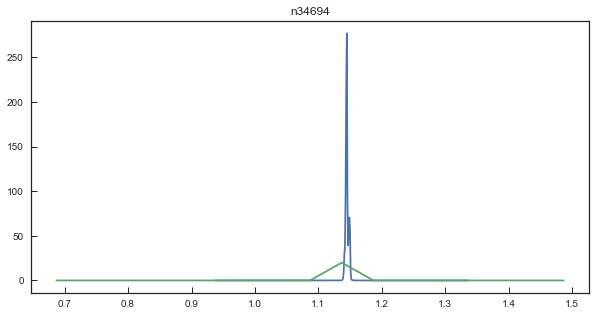

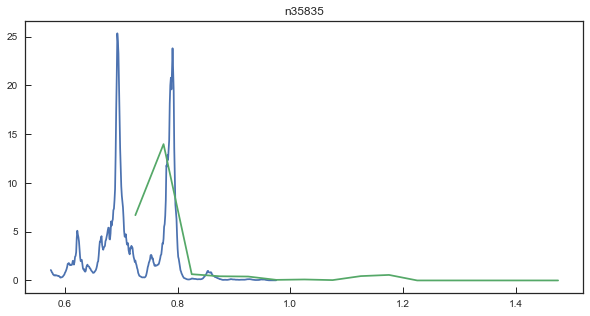

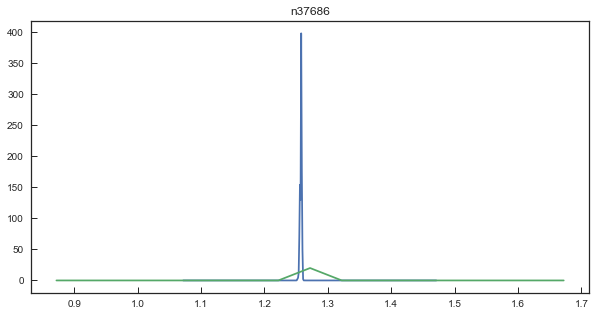

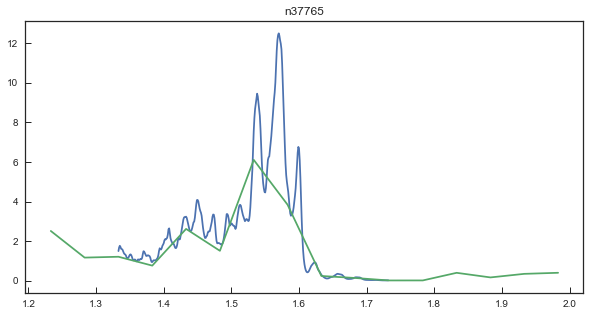

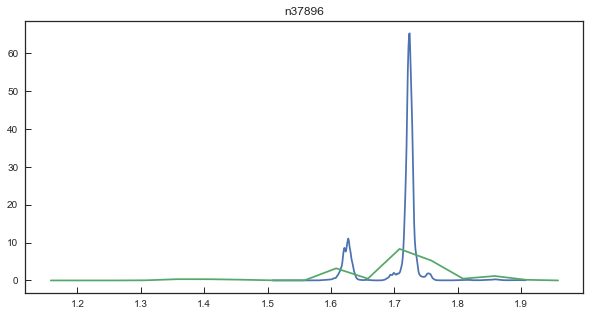

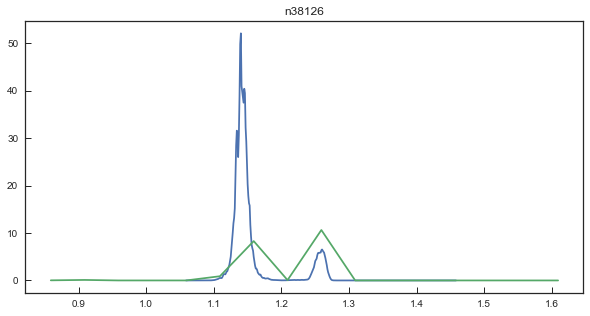

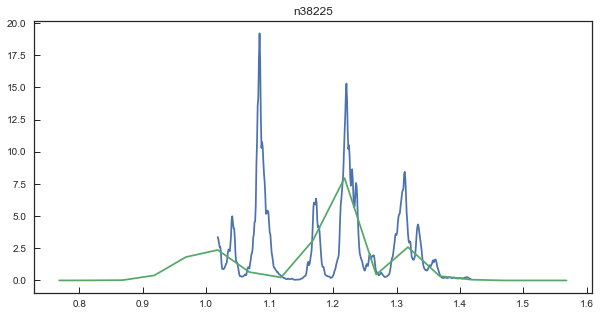

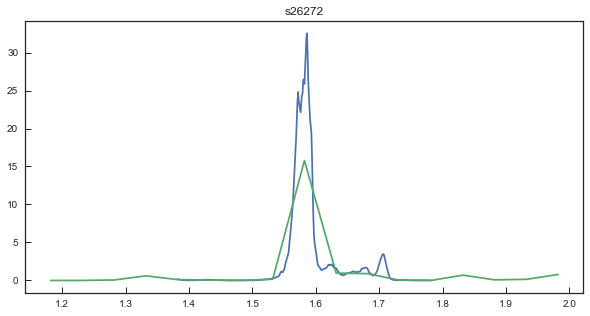

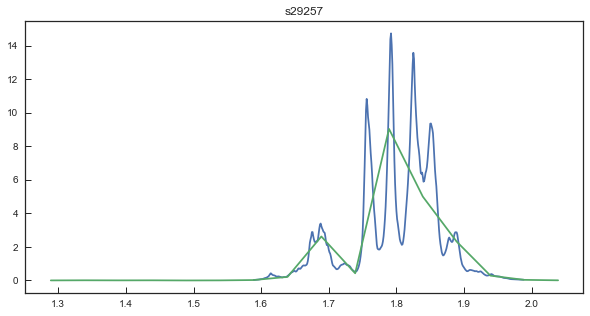

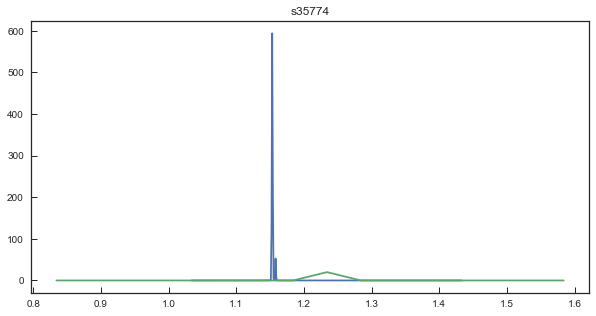

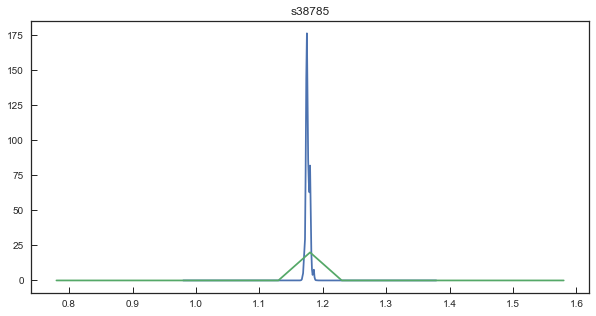

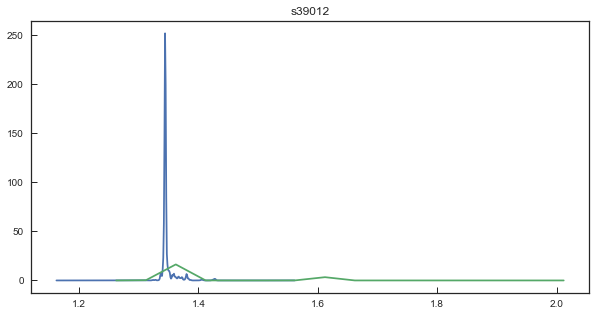

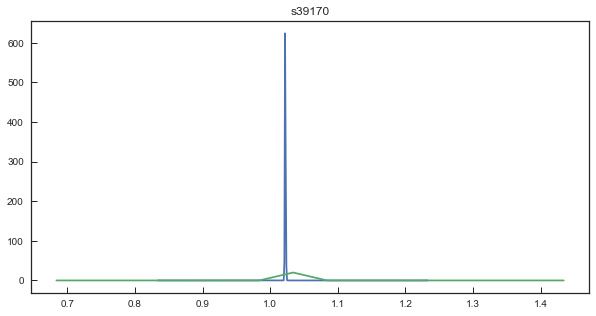

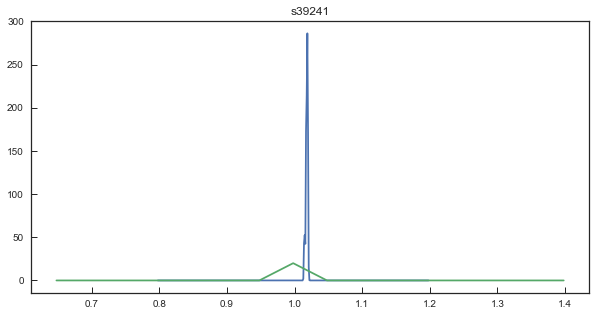

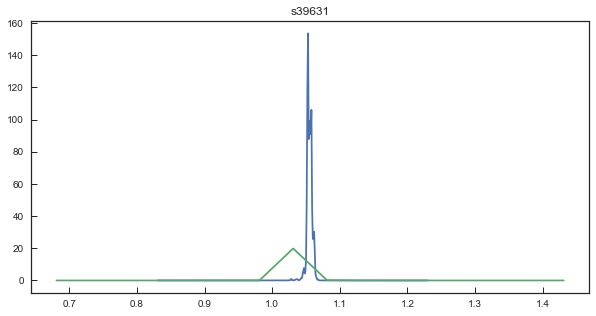

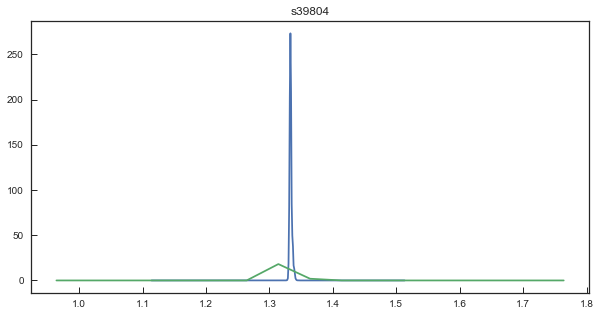

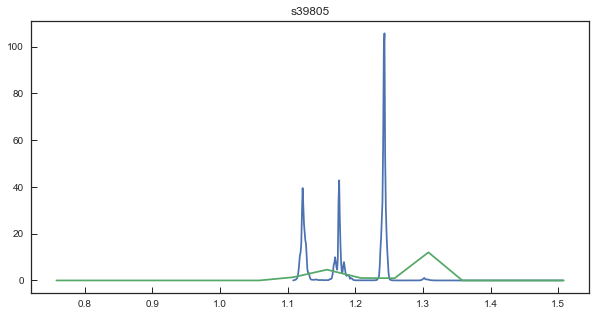

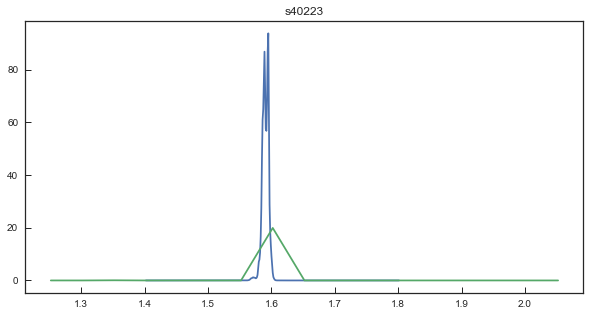

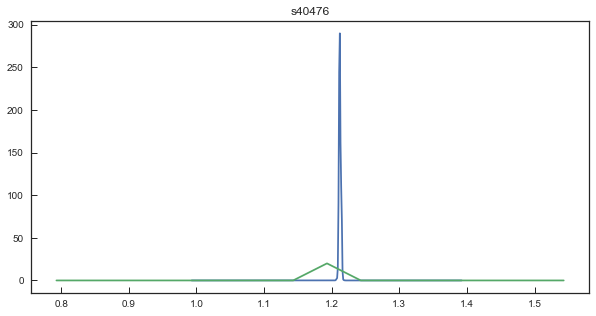

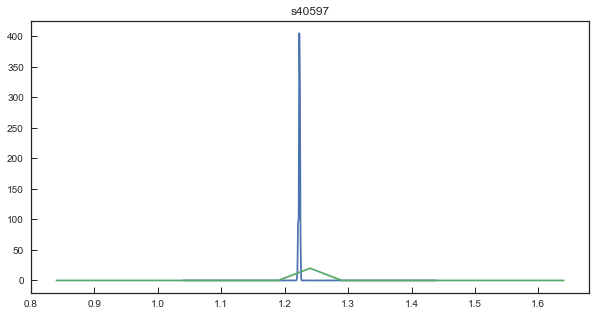

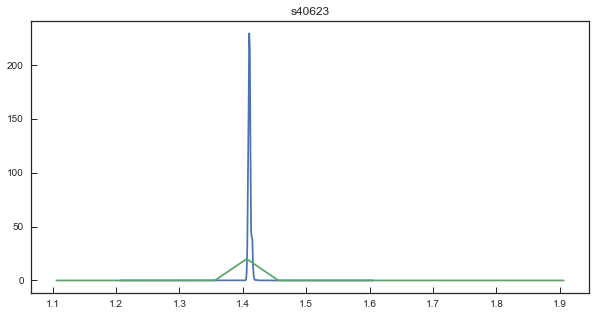

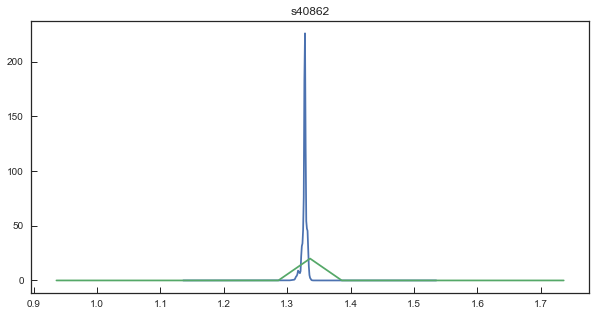

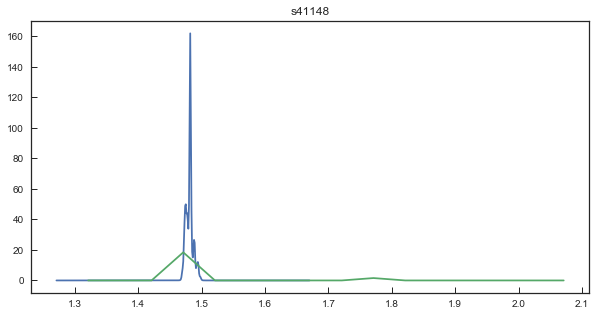

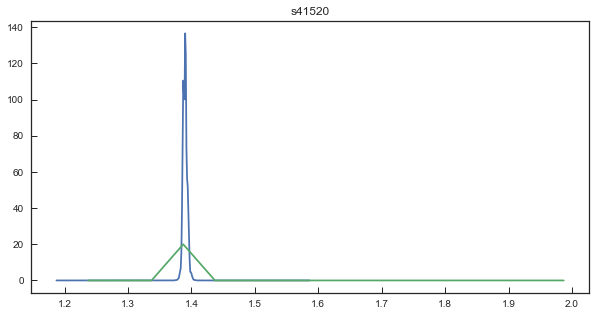

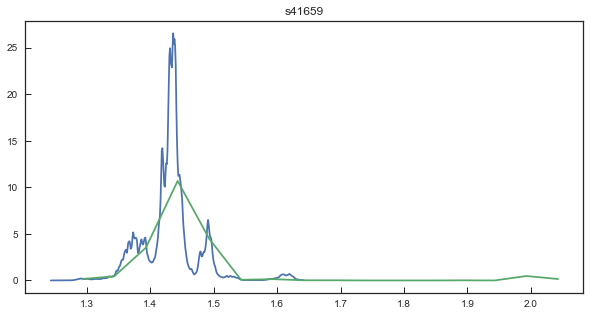

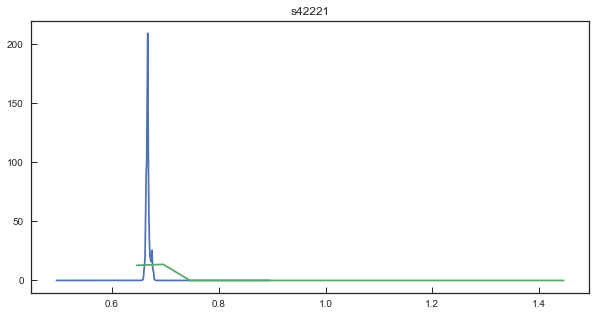

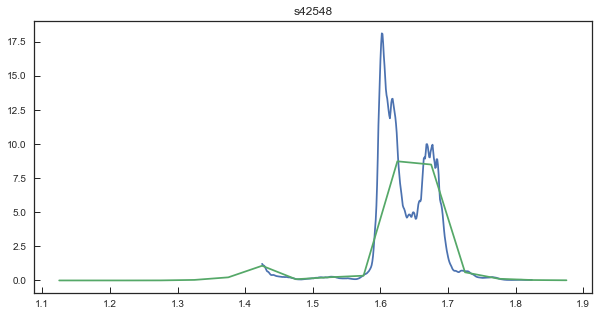

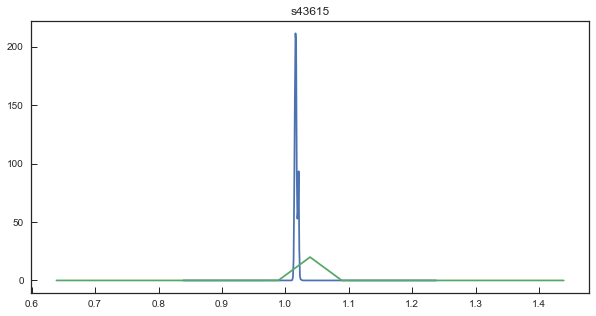

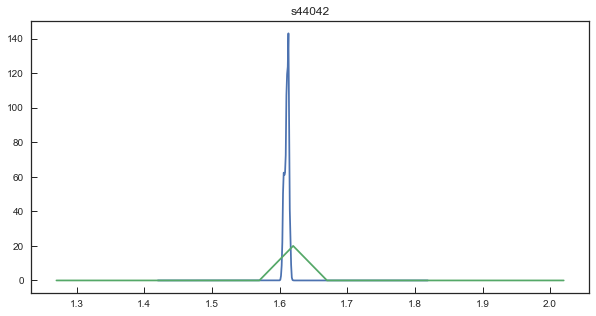

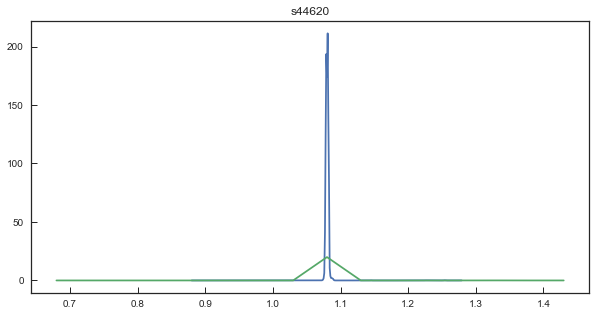

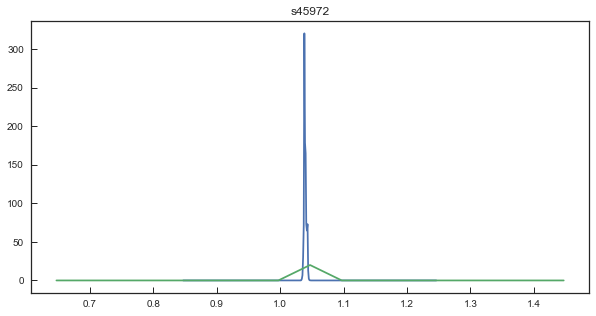

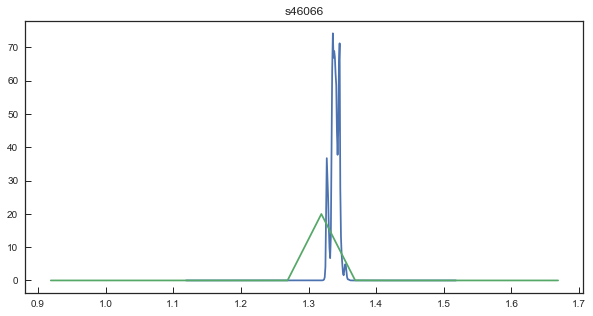

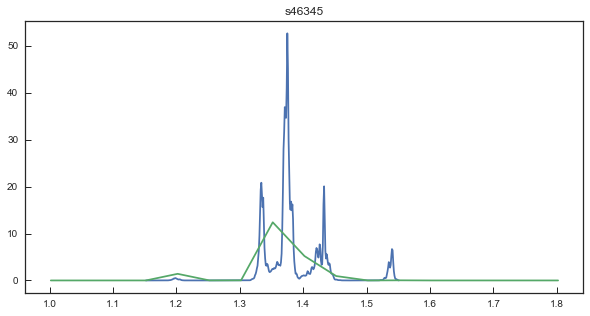

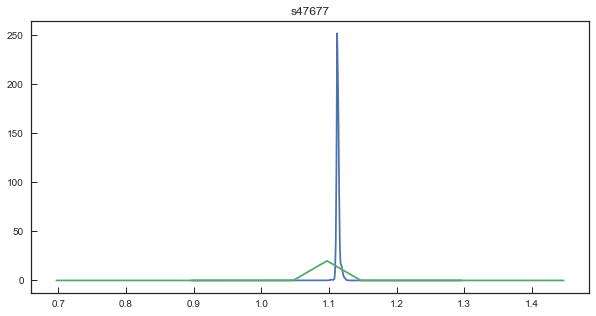

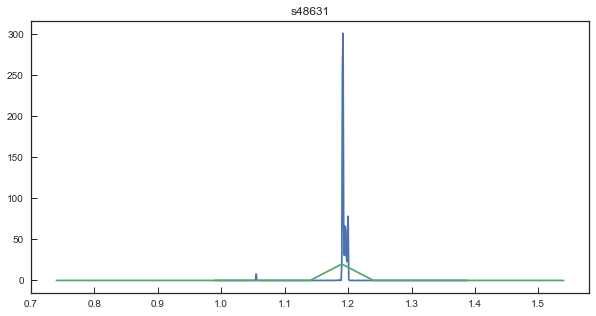

In [24]:
%matplotlib inline

hr_specz = np.zeros(len(hr_list))

for i in range(len(hr_specz)):
    z,pz=np.load(hr_list[i])
    zl,pzl=np.load(lr_list[i])
    # hr_specz[i] = z[np.argmax(pz)]
    plt.figure(figsize=[10,5])
    plt.plot(z,pz)
    plt.plot(zl,pzl)
    plt.title(gsDB['gids'][gsDB.index[i]])
    plt.show()
    plt.close()

In [12]:
gsDB['hi_res_specz'] = hr_specz

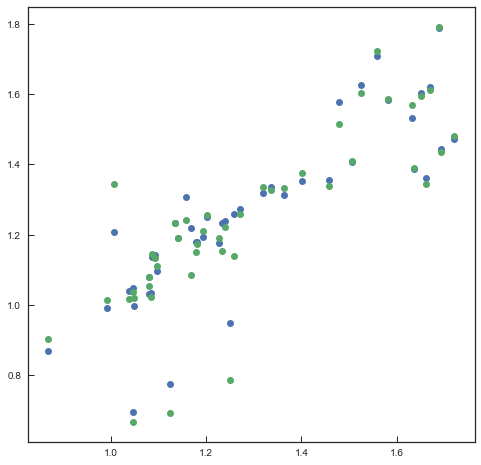

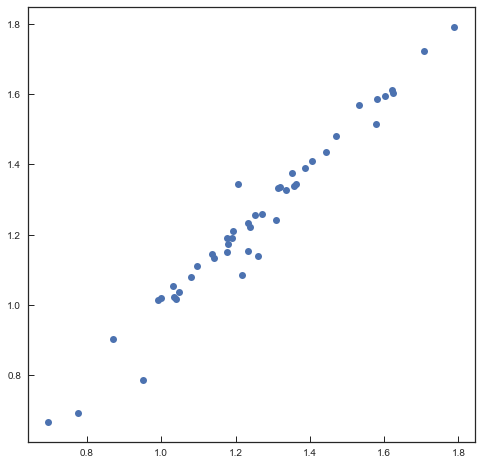

In [19]:
plt.figure(figsize=[8,8])
plt.plot(gsDB['redshift'],gsDB['low_res_specz'],'o')
plt.plot(gsDB['redshift'],gsDB['hi_res_specz'],'o')
plt.show()
plt.close()

plt.figure(figsize=[8,8])
plt.plot(gsDB['low_res_specz'],gsDB['hi_res_specz'],'o')
plt.show()
plt.close()

No TEAL-based tasks available for this package!


../data/galaxy_flts/n14713_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n14713_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n14713_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n14713_flt: save ../data/galaxy_flts/n14713_flt.detect_seg.fits, ../data/galaxy_flts/n14713_flt.detect.cat


/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/grizli/model.py:496: RuntimeWarning: invalid value encountered in divide
  self.optimal_profile = m/m.sum(axis=0)


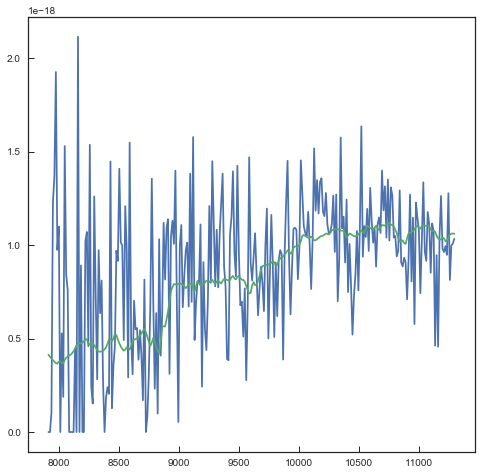

../data/galaxy_flts/n15616_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n15616_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n15616_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n15616_flt: save ../data/galaxy_flts/n15616_flt.detect_seg.fits, ../data/galaxy_flts/n15616_flt.detect.cat


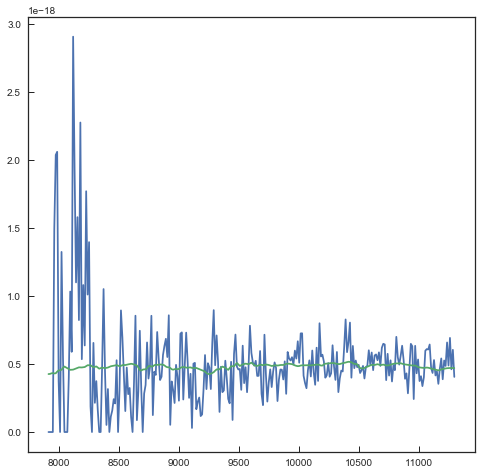

../data/galaxy_flts/n16758_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n16758_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n16758_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n16758_flt: save ../data/galaxy_flts/n16758_flt.detect_seg.fits, ../data/galaxy_flts/n16758_flt.detect.cat


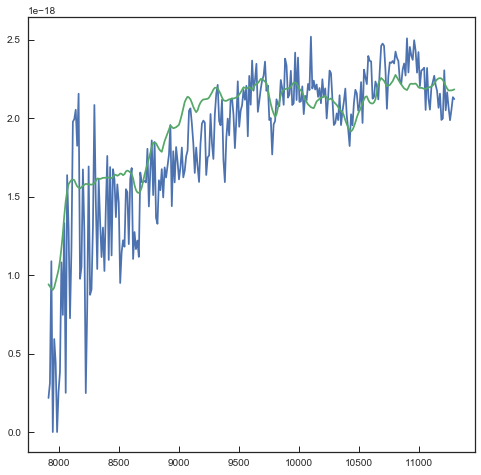

../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


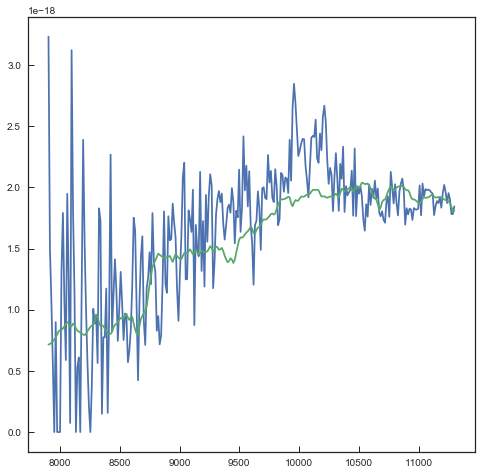

../data/galaxy_flts/n17436_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17436_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17436_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17436_flt: save ../data/galaxy_flts/n17436_flt.detect_seg.fits, ../data/galaxy_flts/n17436_flt.detect.cat


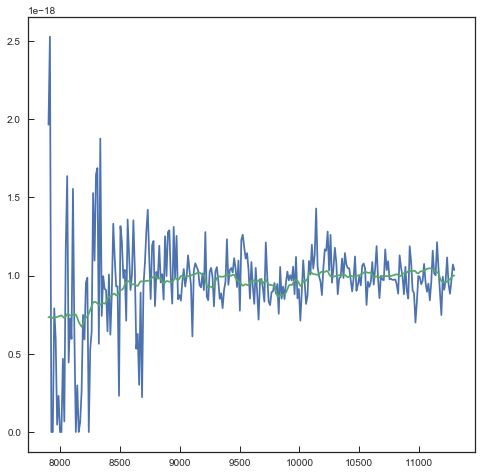

../data/galaxy_flts/n19442_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n19442_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n19442_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n19442_flt: save ../data/galaxy_flts/n19442_flt.detect_seg.fits, ../data/galaxy_flts/n19442_flt.detect.cat


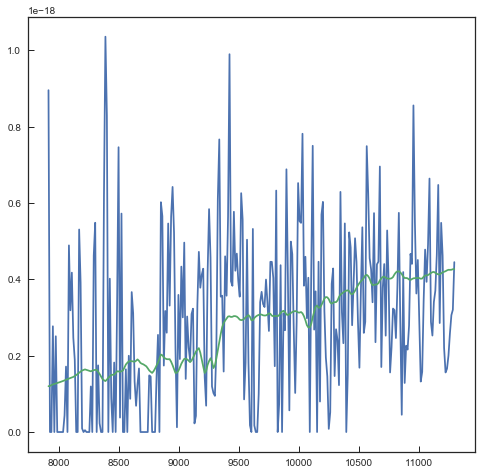

../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


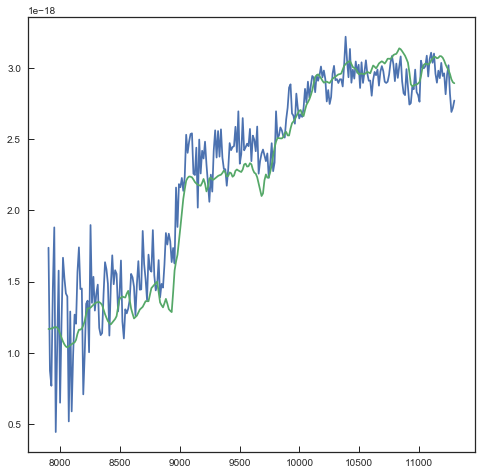

../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


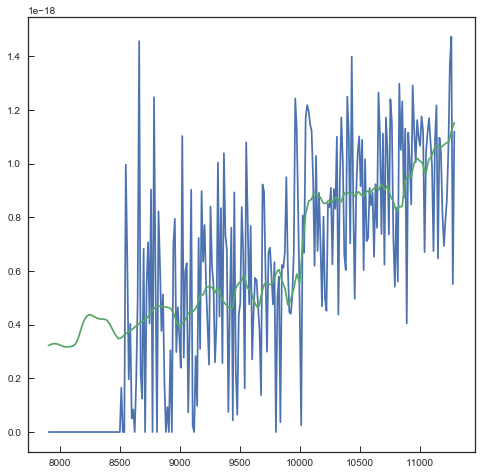

../data/galaxy_flts/n23254_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n23254_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n23254_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n23254_flt: save ../data/galaxy_flts/n23254_flt.detect_seg.fits, ../data/galaxy_flts/n23254_flt.detect.cat


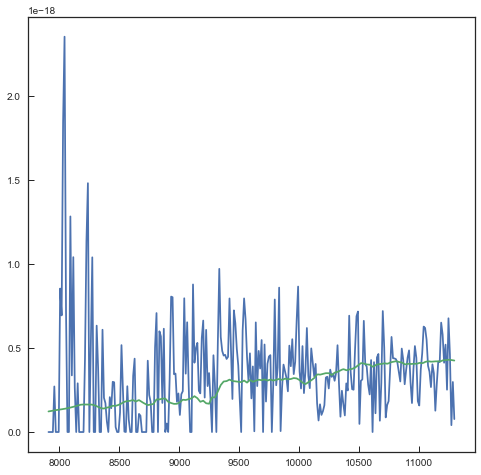

../data/galaxy_flts/n23435_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n23435_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n23435_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n23435_flt: save ../data/galaxy_flts/n23435_flt.detect_seg.fits, ../data/galaxy_flts/n23435_flt.detect.cat


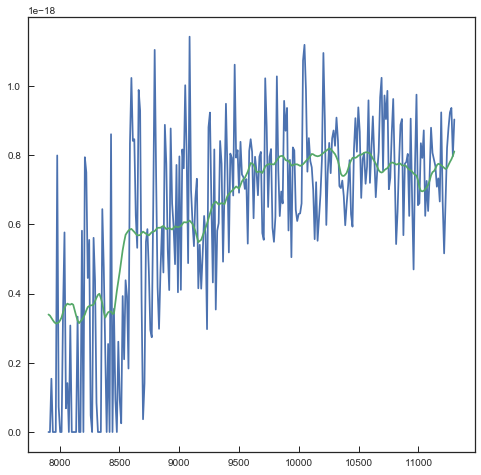

../data/galaxy_flts/n32566_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n32566_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n32566_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n32566_flt: save ../data/galaxy_flts/n32566_flt.detect_seg.fits, ../data/galaxy_flts/n32566_flt.detect.cat


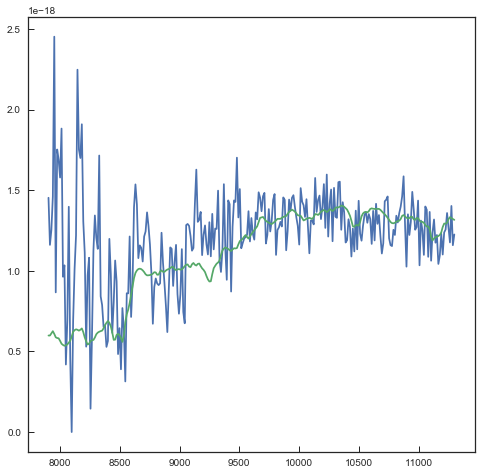

../data/galaxy_flts/n34694_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n34694_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n34694_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n34694_flt: save ../data/galaxy_flts/n34694_flt.detect_seg.fits, ../data/galaxy_flts/n34694_flt.detect.cat


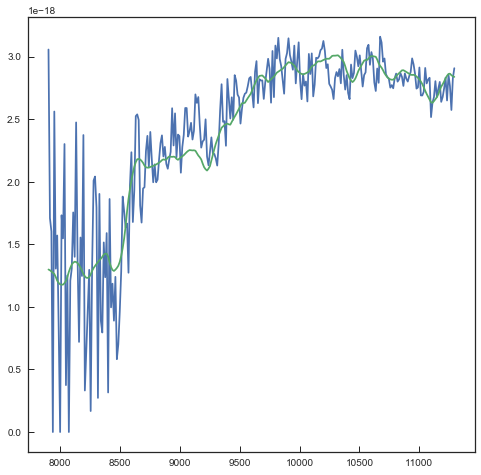

../data/galaxy_flts/n35835_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n35835_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n35835_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/n35835_flt: save ../data/galaxy_flts/n35835_flt.detect_seg.fits, ../data/galaxy_flts/n35835_flt.detect.cat


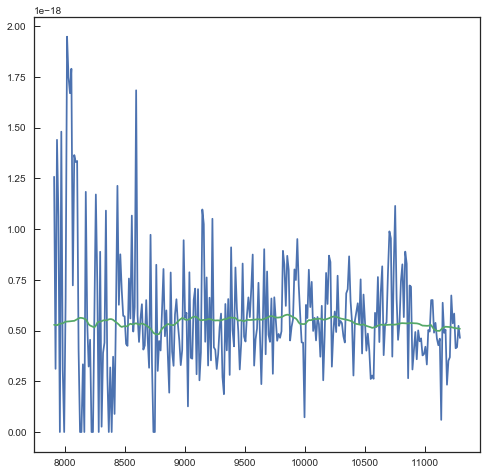

../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat

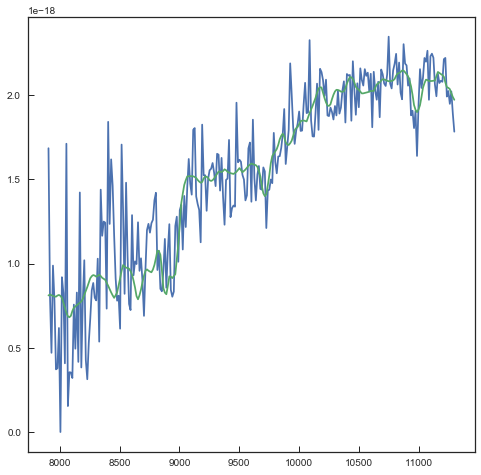

../data/galaxy_flts/n37765_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37765_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37765_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37765_flt: save ../data/galaxy_flts/n37765_flt.detect_seg.fits, ../data/galaxy_flts/n37765_flt.detect.cat


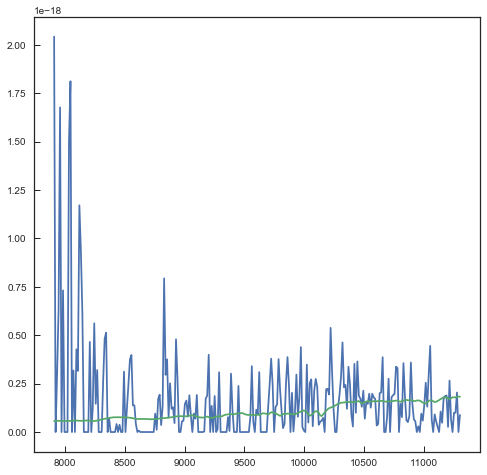

../data/galaxy_flts/n37896_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37896_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37896_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37896_flt: save ../data/galaxy_flts/n37896_flt.detect_seg.fits, ../data/galaxy_flts/n37896_flt.detect.cat


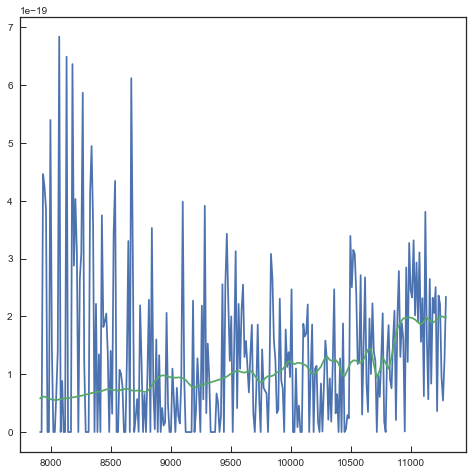

../data/galaxy_flts/n38126_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n38126_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n38126_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n38126_flt: save ../data/galaxy_flts/n38126_flt.detect_seg.fits, ../data/galaxy_flts/n38126_flt.detect.cat


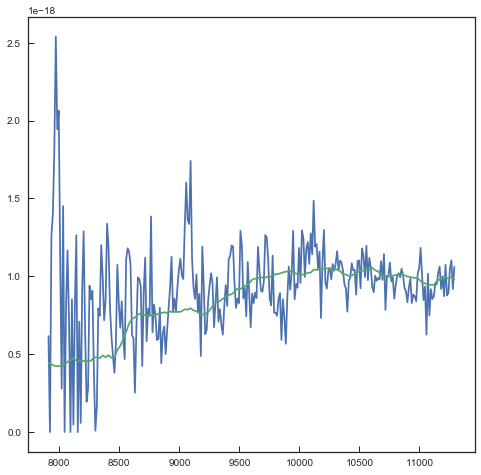

../data/galaxy_flts/n38225_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n38225_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n38225_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n38225_flt: save ../data/galaxy_flts/n38225_flt.detect_seg.fits, ../data/galaxy_flts/n38225_flt.detect.cat


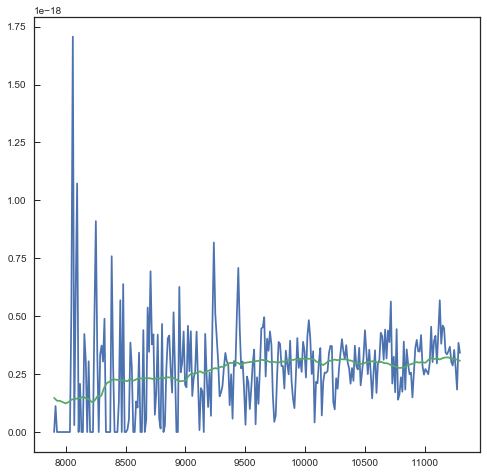

../data/galaxy_flts/s26272_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s26272_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s26272_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s26272_flt: save ../data/galaxy_flts/s26272_flt.detect_seg.fits, ../data/galaxy_flts/s26272_flt.detect.cat


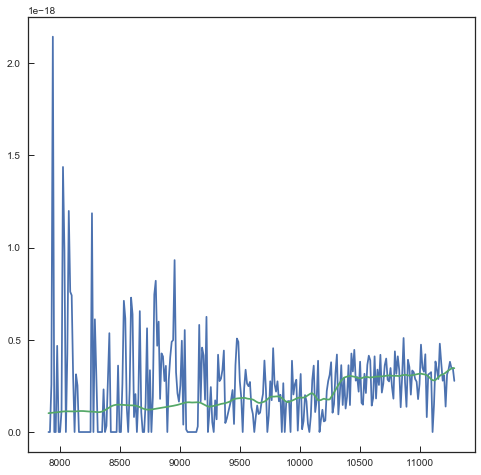

../data/galaxy_flts/s29257_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s29257_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s29257_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s29257_flt: save ../data/galaxy_flts/s29257_flt.detect_seg.fits, ../data/galaxy_flts/s29257_flt.detect.cat


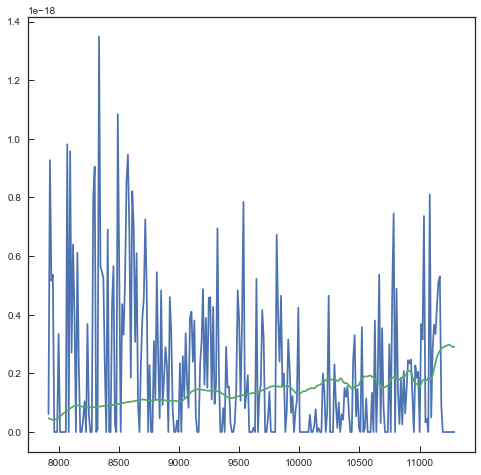

/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/grizli/model.py:1023: RuntimeWarning: invalid value encountered in less
  bad = self.data['SCI'] < sigma*self.data['ERR']


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat


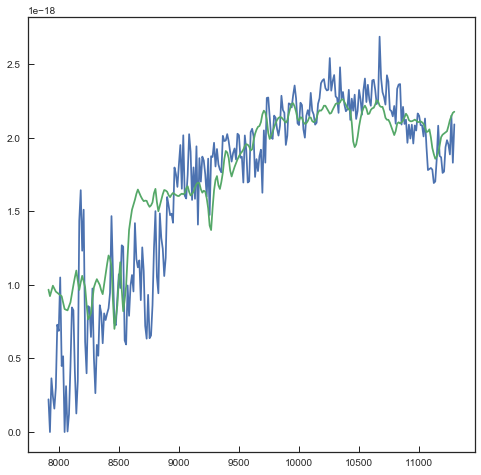

../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


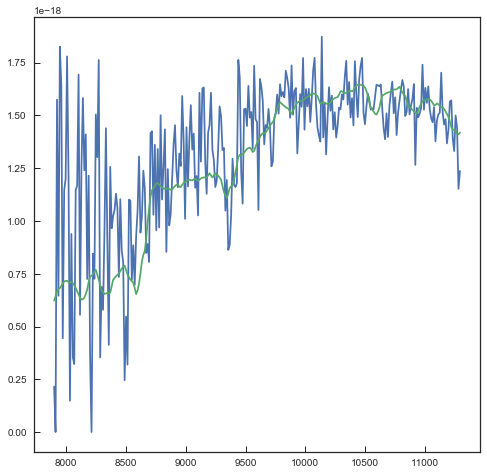

../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects


../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


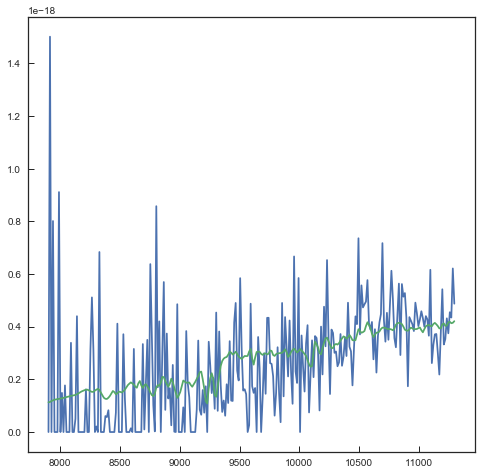

../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat

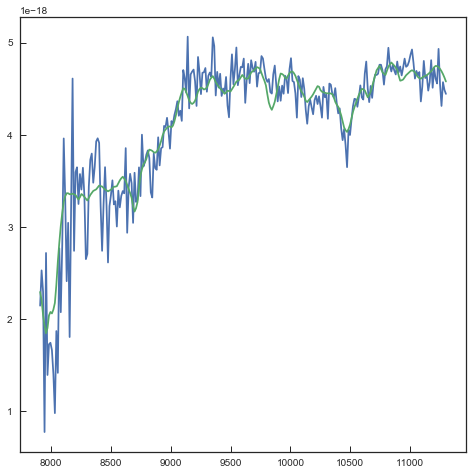

../data/galaxy_flts/s39241_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39241_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39241_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39241_flt: save ../data/galaxy_flts/s39241_flt.detect_seg.fits, ../data/galaxy_flts/s39241_flt.detect.cat


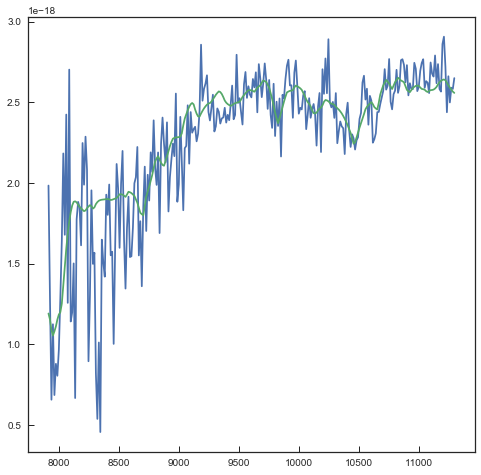

../data/galaxy_flts/s39631_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39631_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39631_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39631_flt: save ../data/galaxy_flts/s39631_flt.detect_seg.fits, ../data/galaxy_flts/s39631_flt.detect.cat


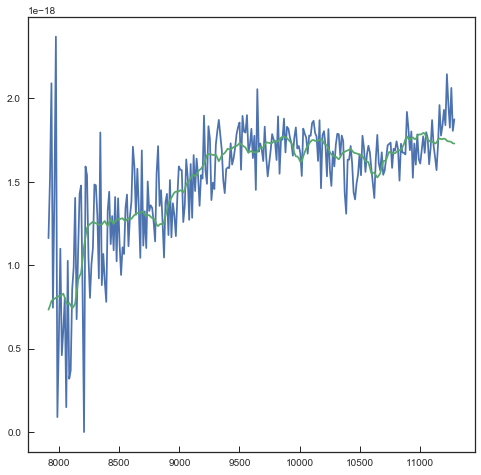

../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


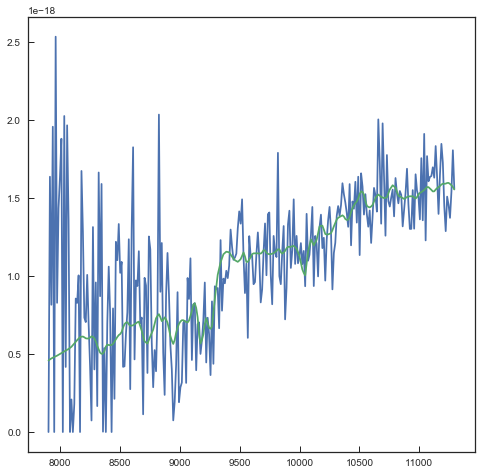

../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


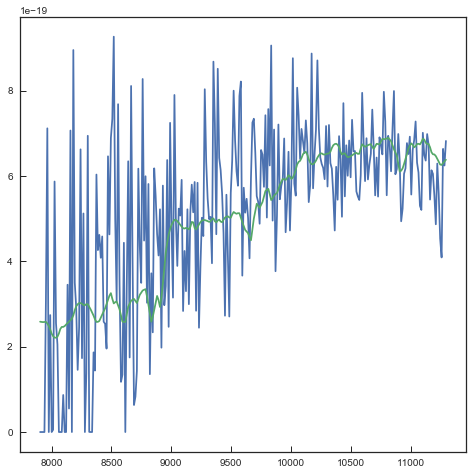

../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


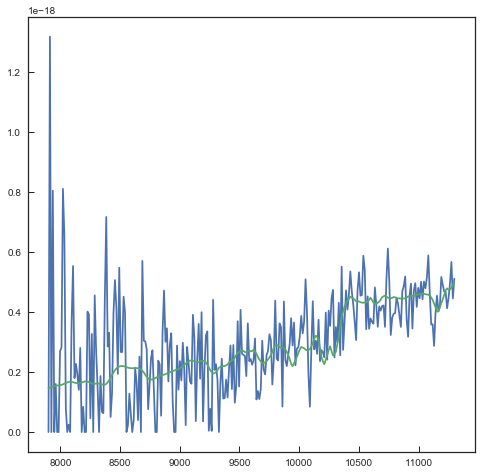

../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


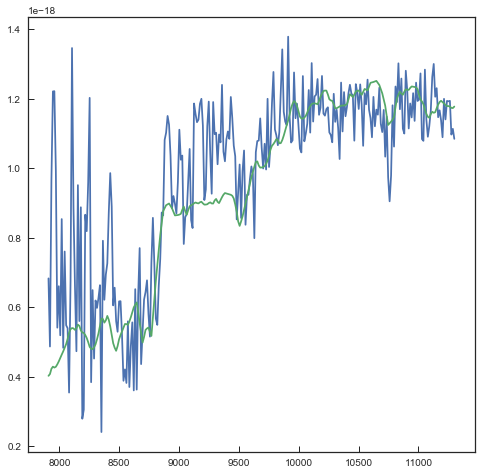

../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


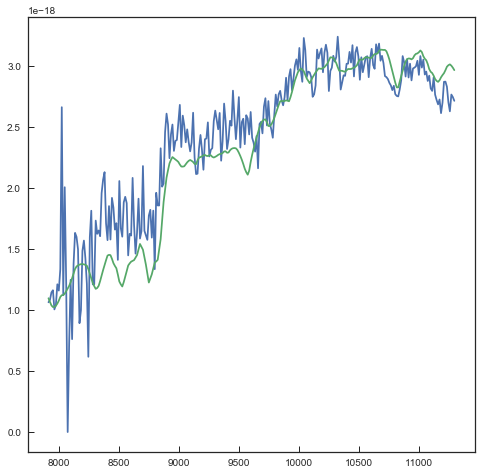

../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


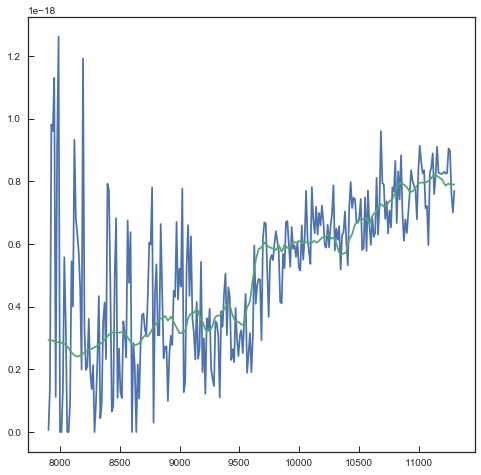

../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


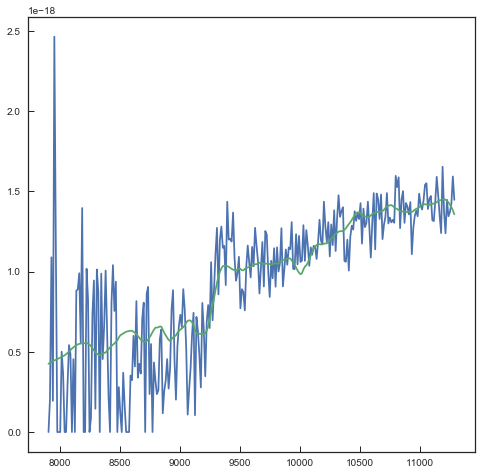

../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


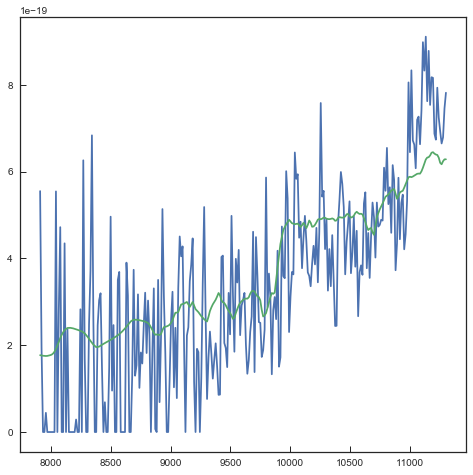

../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


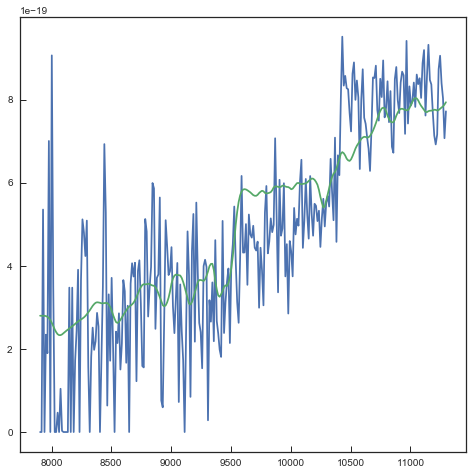

../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat


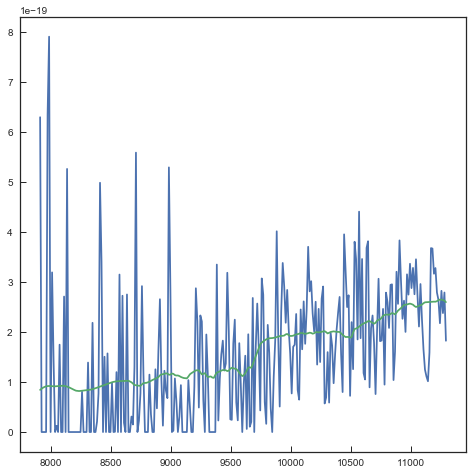

../data/galaxy_flts/s42221_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s42221_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s42221_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s42221_flt: save ../data/galaxy_flts/s42221_flt.detect_seg.fits, ../data/galaxy_flts/s42221_flt.detect.cat

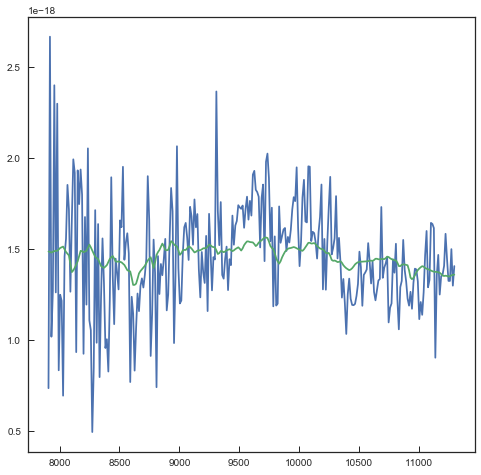

../data/galaxy_flts/s42548_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s42548_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s42548_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s42548_flt: save ../data/galaxy_flts/s42548_flt.detect_seg.fits, ../data/galaxy_flts/s42548_flt.detect.cat


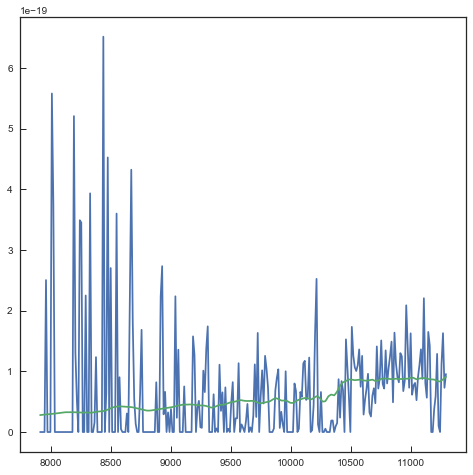

../data/galaxy_flts/s43615_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s43615_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s43615_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s43615_flt: save ../data/galaxy_flts/s43615_flt.detect_seg.fits, ../data/galaxy_flts/s43615_flt.detect.cat


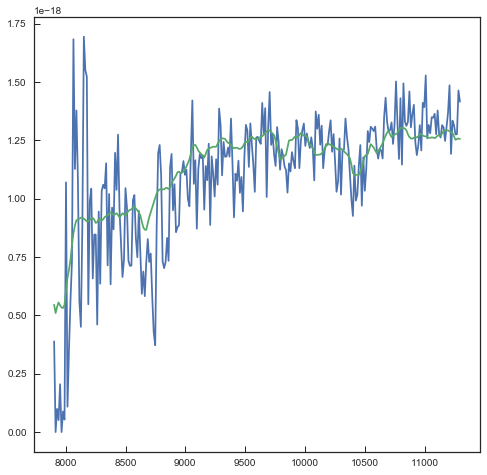

../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


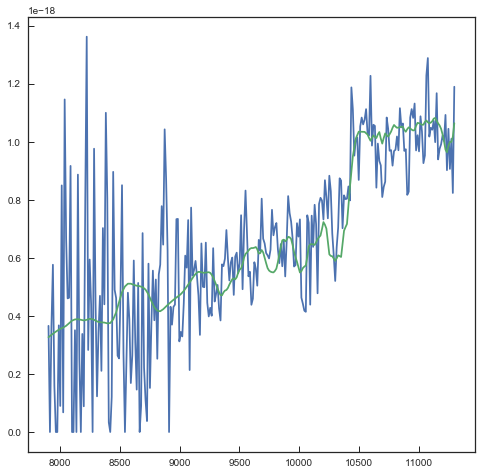

../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


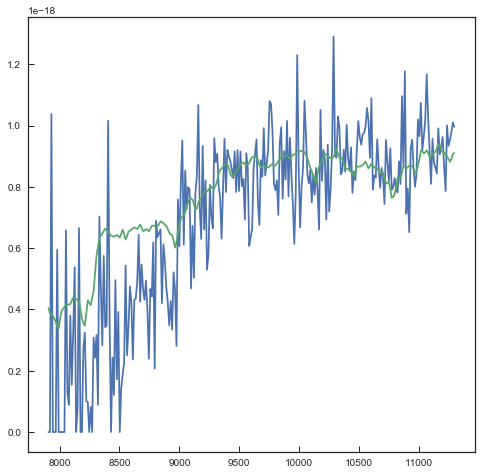

../data/galaxy_flts/s45972_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s45972_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s45972_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s45972_flt: save ../data/galaxy_flts/s45972_flt.detect_seg.fits, ../data/galaxy_flts/s45972_flt.detect.cat


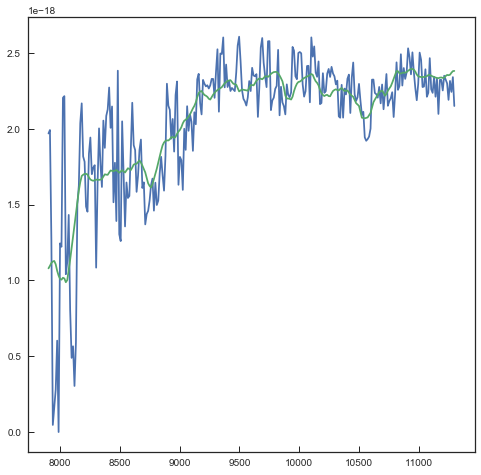

../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


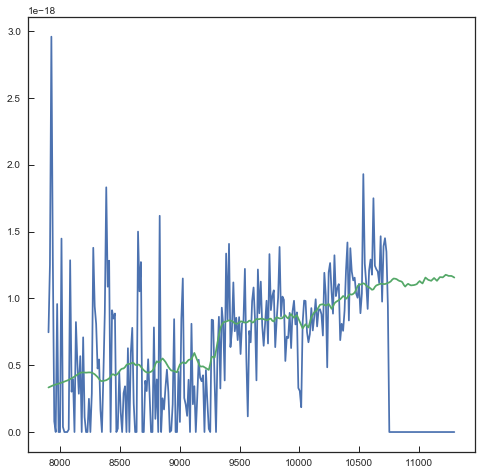

../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


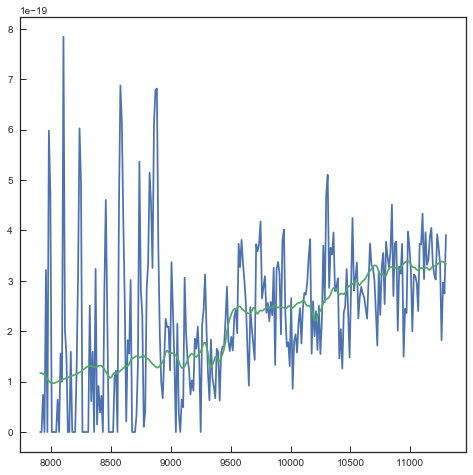

../data/galaxy_flts/s47677_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s47677_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s47677_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s47677_flt: save ../data/galaxy_flts/s47677_flt.detect_seg.fits, ../data/galaxy_flts/s47677_flt.detect.cat


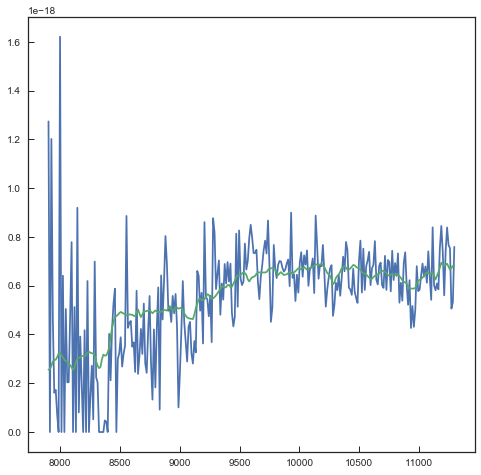

../data/galaxy_flts/s48631_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s48631_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s48631_flt: photutils.source_properties - 2 objects


../data/galaxy_flts/s48631_flt: save ../data/galaxy_flts/s48631_flt.detect_seg.fits, ../data/galaxy_flts/s48631_flt.detect.cat


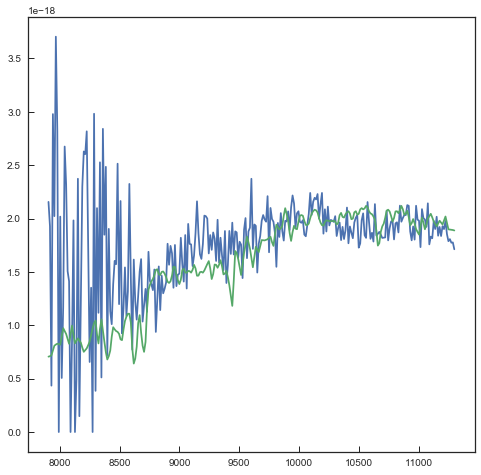

In [20]:
for i in gsDB.index:
    gal_spec = RT_spec(gsDB['gids'][i])
    gal_spec.Sim_spec(0.015,3.5,0,gsDB['hi_res_specz'][i])
    
    plt.figure(figsize=[8,8])
    plt.plot(gal_spec.gal_wv,gal_spec.gal_fl)
    plt.plot(gal_spec.gal_wv,gal_spec.fl)
    plt.show()
    plt.close()

../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects


../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


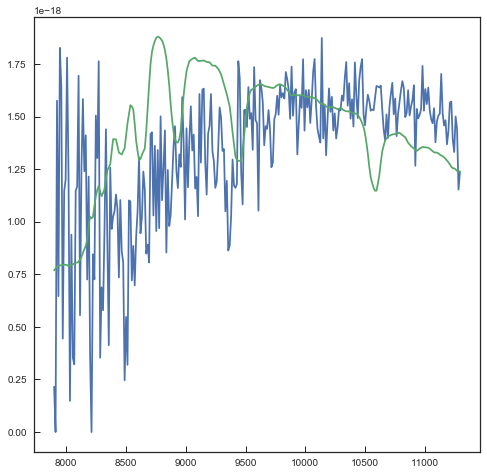

In [21]:
gal_spec = RT_spec(gsDB['gids'][217])
gal_spec.Sim_spec(0.015,0.5,0,gsDB['hi_res_specz'][217])

plt.figure(figsize=[8,8])
plt.plot(gal_spec.gal_wv,gal_spec.gal_fl)
plt.plot(gal_spec.gal_wv,gal_spec.fl)
plt.show()
plt.close()